Generally produced with:

$L=50$, $\eta=0.2$, $\delta=10^{-4}$, $M=10$, $\rho=3800$, $\sigma=3$

In [1]:
import os
import sys
import yaml
import math
import itertools

module_path = os.path.abspath(os.path.join('../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts, flatten_dict
from experiments.dispatch.dispatch_utils import nested_dict_to_option_strings

# plotting
# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [3]:
with open('../experiment_configs/datapoint_damping_T_investigation.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)

database = experiment_config["database"]
experiment_config = flatten_dict(experiment_config)

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)

print(f"Searched config options {experiment_config}")

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
adult_configs = [dict(item) for item in product]

Searched config options {'optimisation_settings.N_steps': [25, 50, 100, 200], 'PVI_settings.damping_factor': [0.2, 0.1, 0.05]}


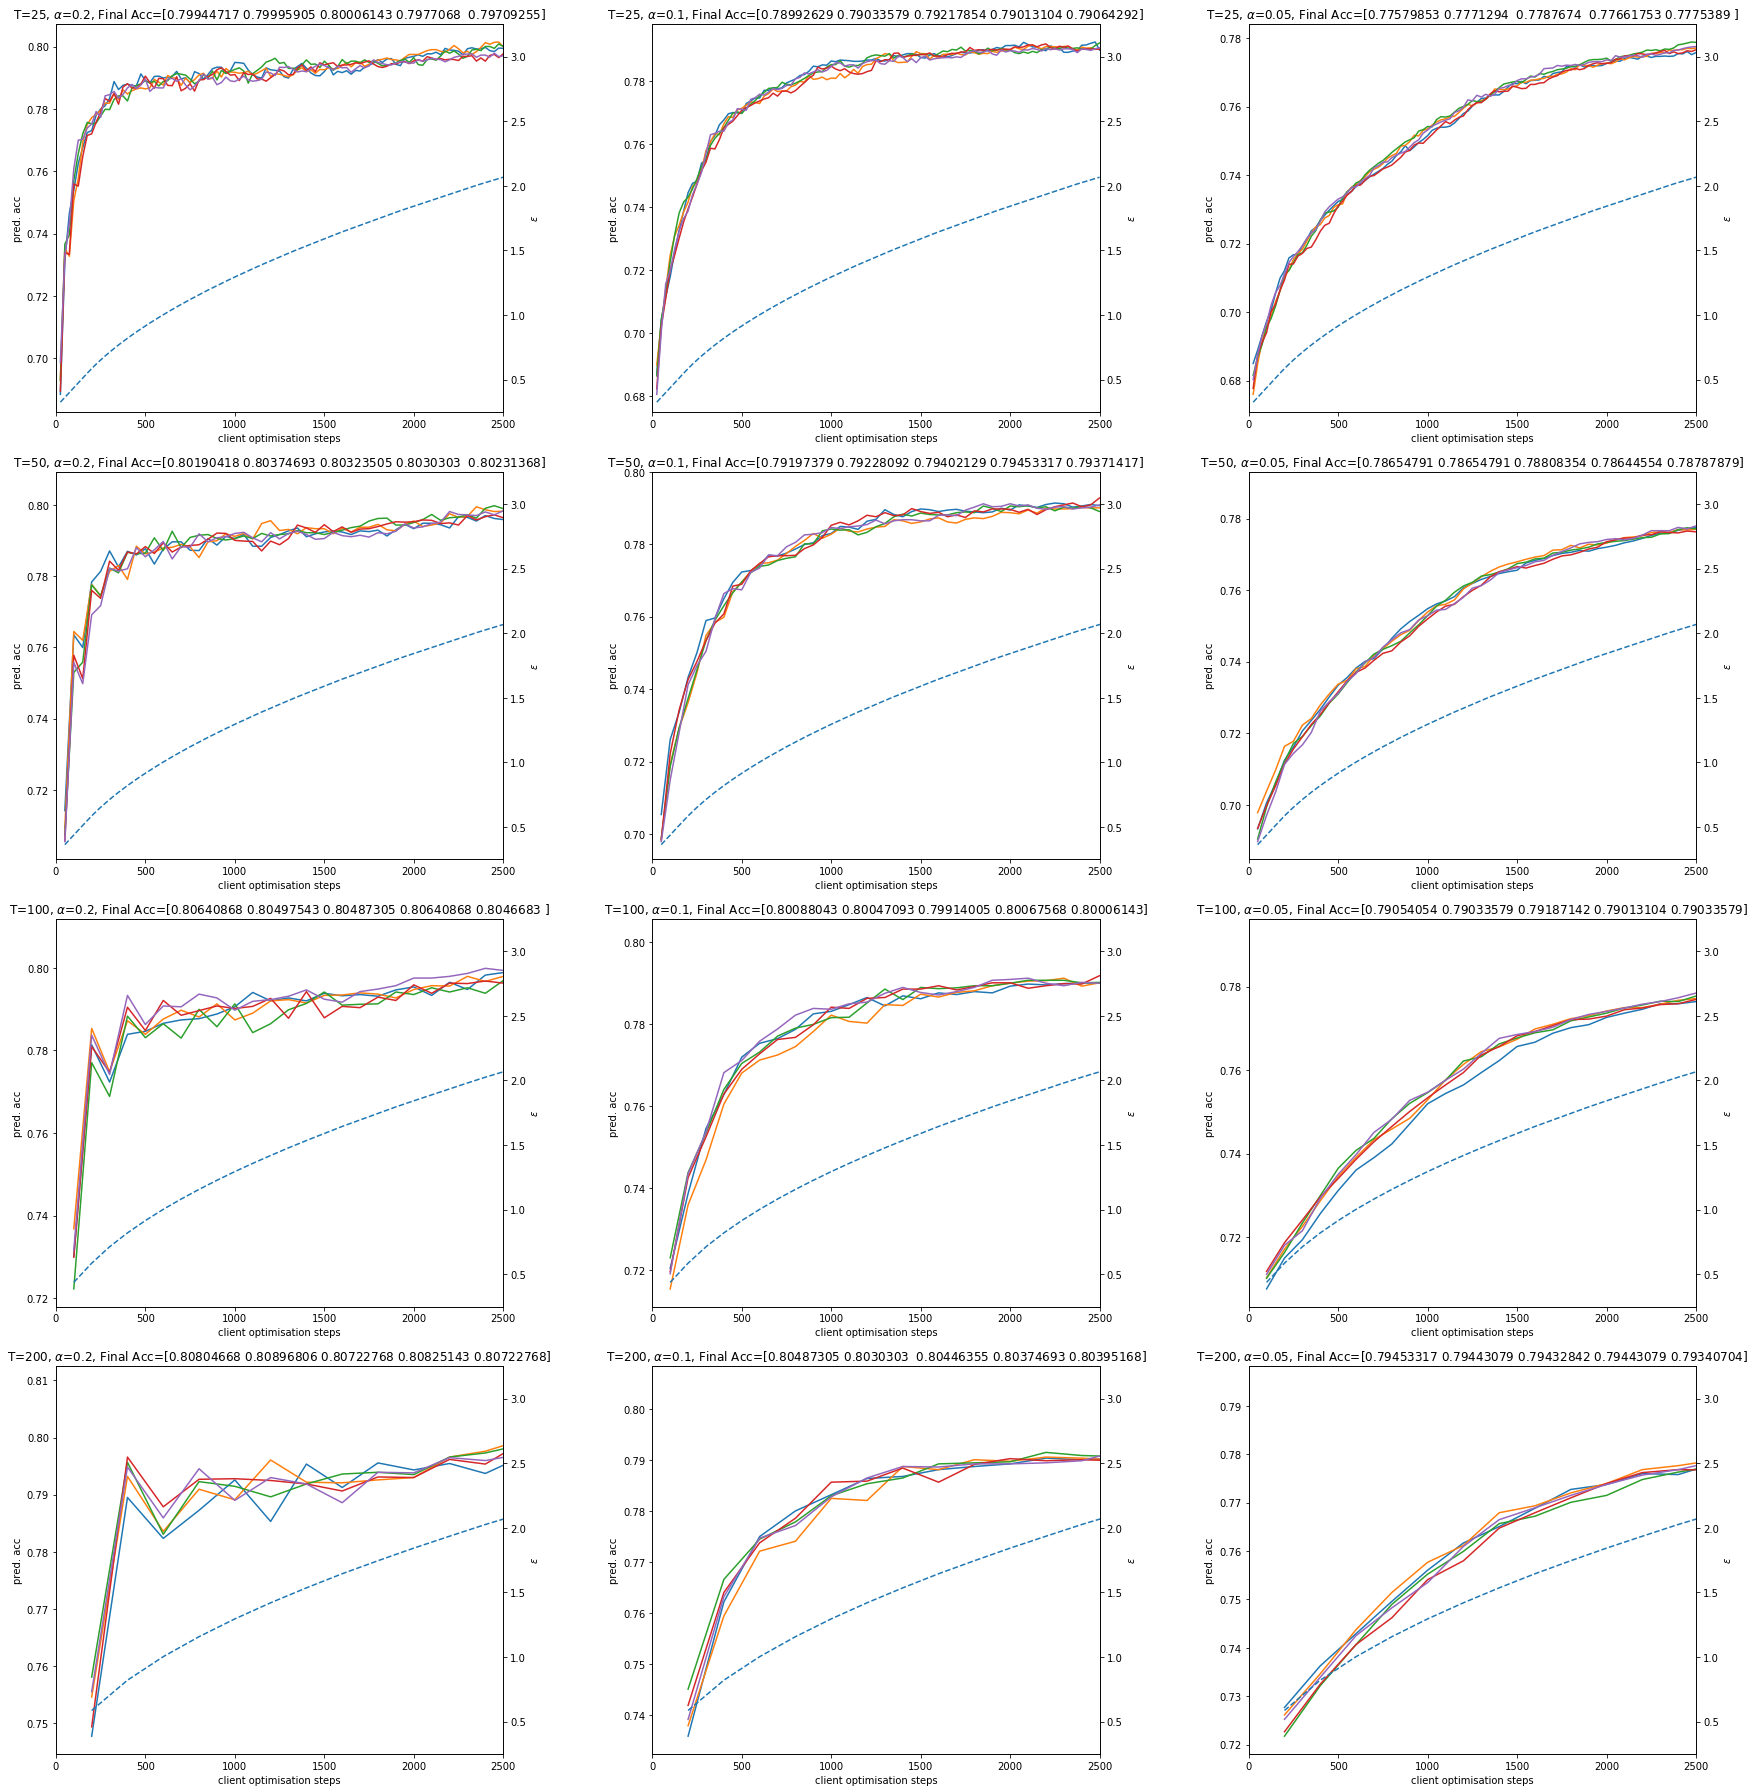

In [5]:
results_access = SacredExperimentAccess(database_name=database)
Ts = experiment_config['optimisation_settings.N_steps']
As = experiment_config['PVI_settings.damping_factor']

adult_grid_experiments = [results_access.get_experiments(name='jalko2017_datapoint_exp', complete=True, config=config) for config in adult_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_grid_experiments]
adult_eps_metrics = [results_access.get_metrics_by_exp(experiments, "epsilon", "in") for experiments in adult_grid_experiments]

plt.figure(figsize=(25,25))
rows = len(Ts)
cols = len(As)

for config, experiments, metrics, eps_metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics, adult_eps_metrics):
    T = config['optimisation_settings.N_steps']
    A = config['PVI_settings.damping_factor']
    
    T_index = Ts.index(T)
    A_index = As.index(A)
    
    axes = plt.subplot(rows, cols, T_index * cols + A_index + 1)
    
        
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T * T
    
    seed_eps_values = []
    for seed_indx, seed_eps in enumerate(eps_metrics):
        eps_values = []
        for client_eps in seed_eps:
            eps_values.append(np.array(client_eps["values"]).flatten())
        eps_values = np.array(eps_values)
        seed_eps_values.append(np.mean(eps_values, 0))
    
    final_mean_eps_values = np.mean(seed_eps_values, 0)
    
    axes2 = axes.twinx()
    
    plt.title(f"T={T}, $\\alpha$={A}, Final Acc={values[-1]}")
    
    axes2.plot(steps, final_mean_eps_values, '--')
    axes2.set_ylabel('$\epsilon$')
    axes2.set_ylim(0.25, 3.25)
    axes.plot(steps, values)
    axes.set_xlabel('client optimisation steps')
    axes.set_ylabel('pred. acc')
    plt.xlim([0, 100*25])
    
plt.tight_layout()

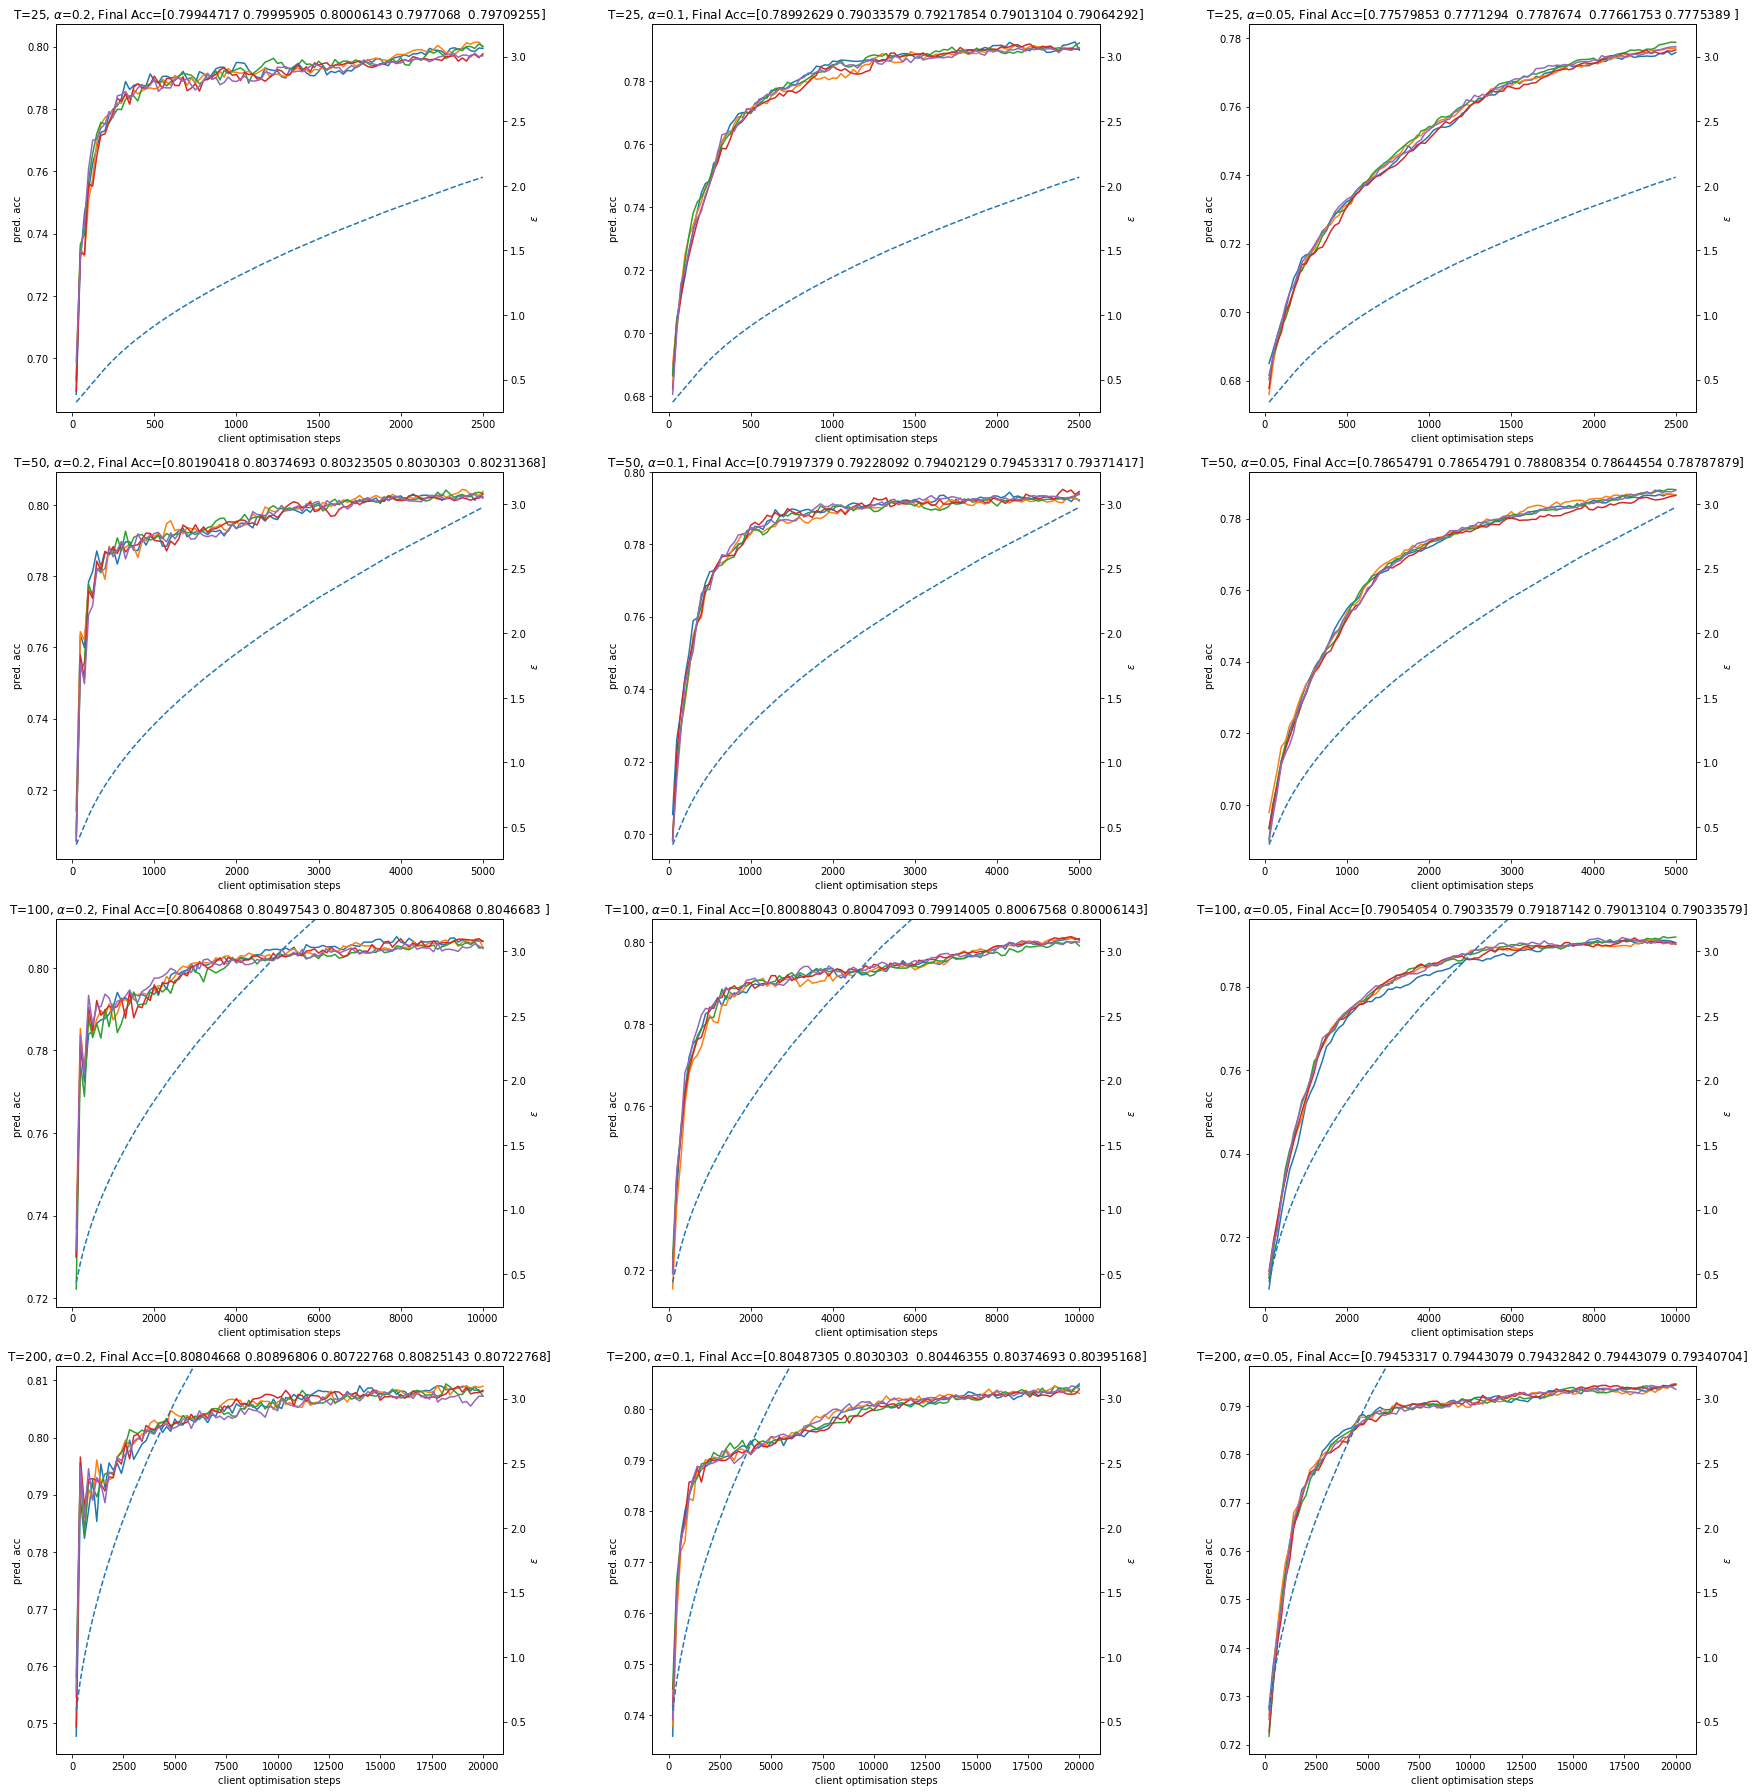

In [7]:
results_access = SacredExperimentAccess(database_name=database)
Ts = experiment_config['optimisation_settings.N_steps']
As = experiment_config['PVI_settings.damping_factor']

adult_grid_experiments = [results_access.get_experiments(name='jalko2017_datapoint_exp', complete=True, config=config) for config in adult_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_grid_experiments]
adult_eps_metrics = [results_access.get_metrics_by_exp(experiments, "epsilon", "in") for experiments in adult_grid_experiments]

plt.figure(figsize=(25,25))
rows = len(Ts)
cols = len(As)

for config, experiments, metrics, eps_metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics, adult_eps_metrics):
    T = config['optimisation_settings.N_steps']
    A = config['PVI_settings.damping_factor']
    
    T_index = Ts.index(T)
    A_index = As.index(A)
    
    axes = plt.subplot(rows, cols, T_index * cols + A_index + 1)
    
        
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T * T
    
    seed_eps_values = []
    for seed_indx, seed_eps in enumerate(eps_metrics):
        eps_values = []
        for client_eps in seed_eps:
            eps_values.append(np.array(client_eps["values"]).flatten())
        eps_values = np.array(eps_values)
        seed_eps_values.append(np.mean(eps_values, 0))
    
    final_mean_eps_values = np.mean(seed_eps_values, 0)
    
    axes2 = axes.twinx()
    
    plt.title(f"T={T}, $\\alpha$={A}, Final Acc={values[-1]}")
    
    axes2.plot(steps, final_mean_eps_values, '--')
    axes.plot(steps, values)
    axes.set_xlabel('client optimisation steps')
    axes.set_ylabel('pred. acc')
    axes2.set_ylabel('$\epsilon$')
    axes2.set_ylim(0.25, 3.25)
    
plt.tight_layout()

# Log Likelihood

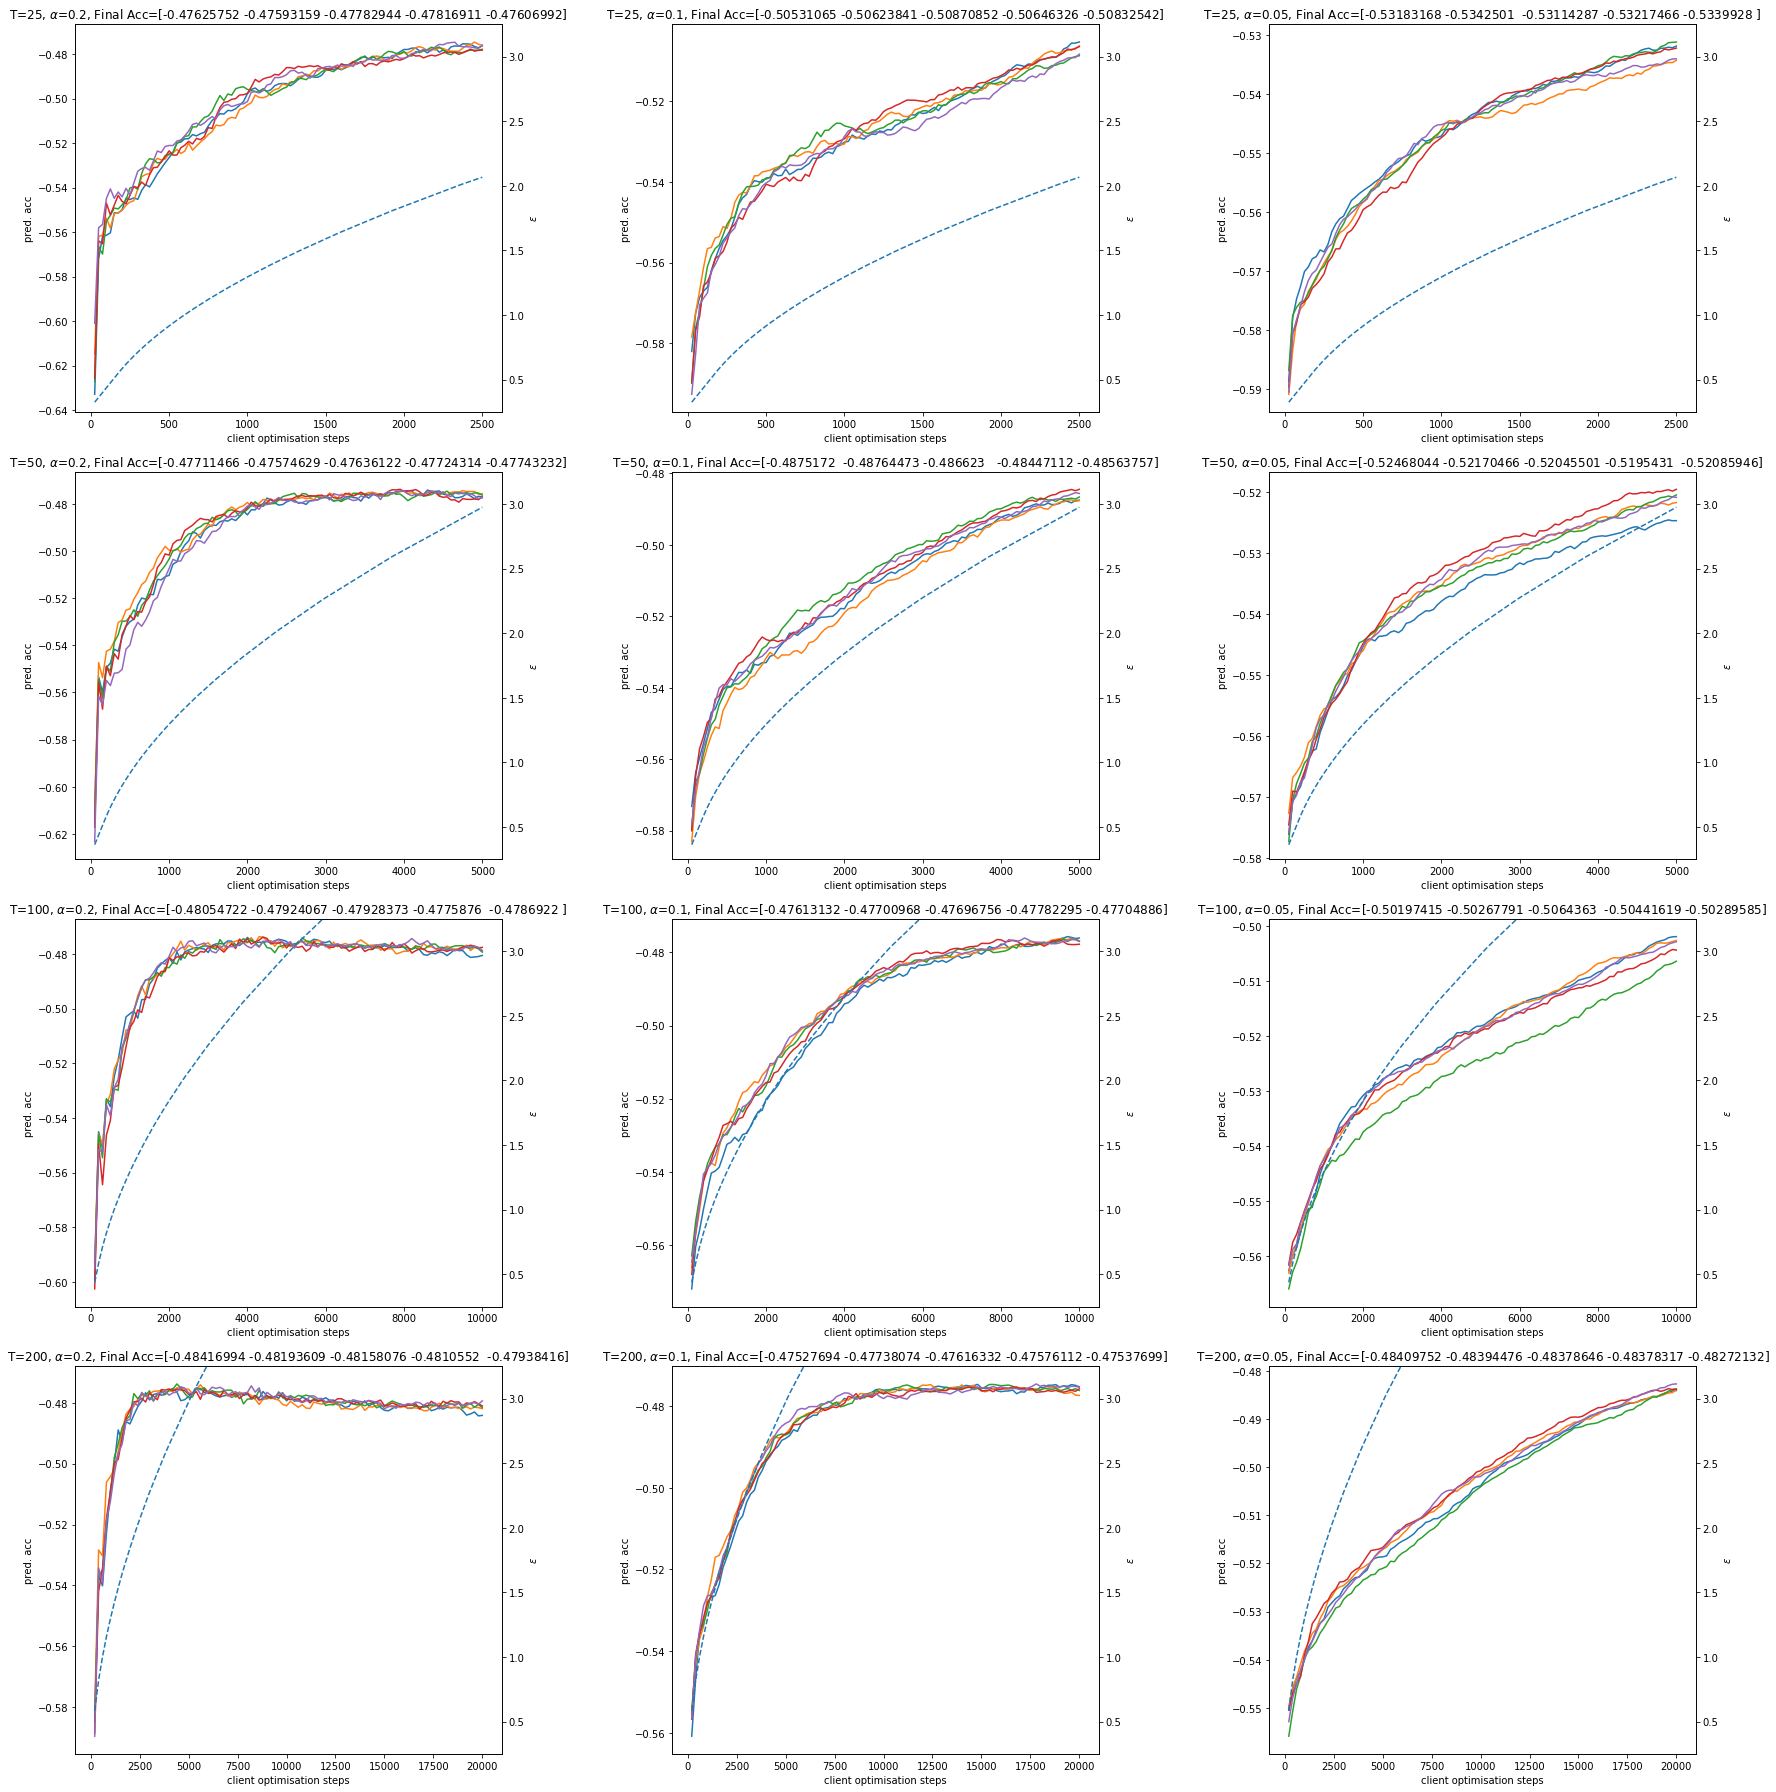

In [9]:
results_access = SacredExperimentAccess(database_name=database)
Ts = experiment_config['optimisation_settings.N_steps']
As = experiment_config['PVI_settings.damping_factor']

adult_grid_experiments = [results_access.get_experiments(name='jalko2017_datapoint_exp', complete=True, config=config) for config in adult_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_all", "train_accuracy"]) for experiments in adult_grid_experiments]
adult_eps_metrics = [results_access.get_metrics_by_exp(experiments, "epsilon", "in") for experiments in adult_grid_experiments]

plt.figure(figsize=(25,25))
rows = len(Ts)
cols = len(As)

for config, experiments, metrics, eps_metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics, adult_eps_metrics):
    T = config['optimisation_settings.N_steps']
    A = config['PVI_settings.damping_factor']
    
    T_index = Ts.index(T)
    A_index = As.index(A)
    
    axes = plt.subplot(rows, cols, T_index * cols + A_index + 1)
    
        
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T * T
    
    seed_eps_values = []
    for seed_indx, seed_eps in enumerate(eps_metrics):
        eps_values = []
        for client_eps in seed_eps:
            eps_values.append(np.array(client_eps["values"]).flatten())
        eps_values = np.array(eps_values)
        seed_eps_values.append(np.mean(eps_values, 0))
    
    final_mean_eps_values = np.mean(seed_eps_values, 0)
    
    axes2 = axes.twinx()
    
    plt.title(f"T={T}, $\\alpha$={A}, Final Acc={values[-1]}")
    
    axes2.plot(steps, final_mean_eps_values, '--')
    axes.plot(steps, values)
    axes.set_xlabel('client optimisation steps')
    axes.set_ylabel('pred. acc')
    axes2.set_ylabel('$\epsilon$')
    axes2.set_ylim(0.25, 3.25)
    
plt.tight_layout()

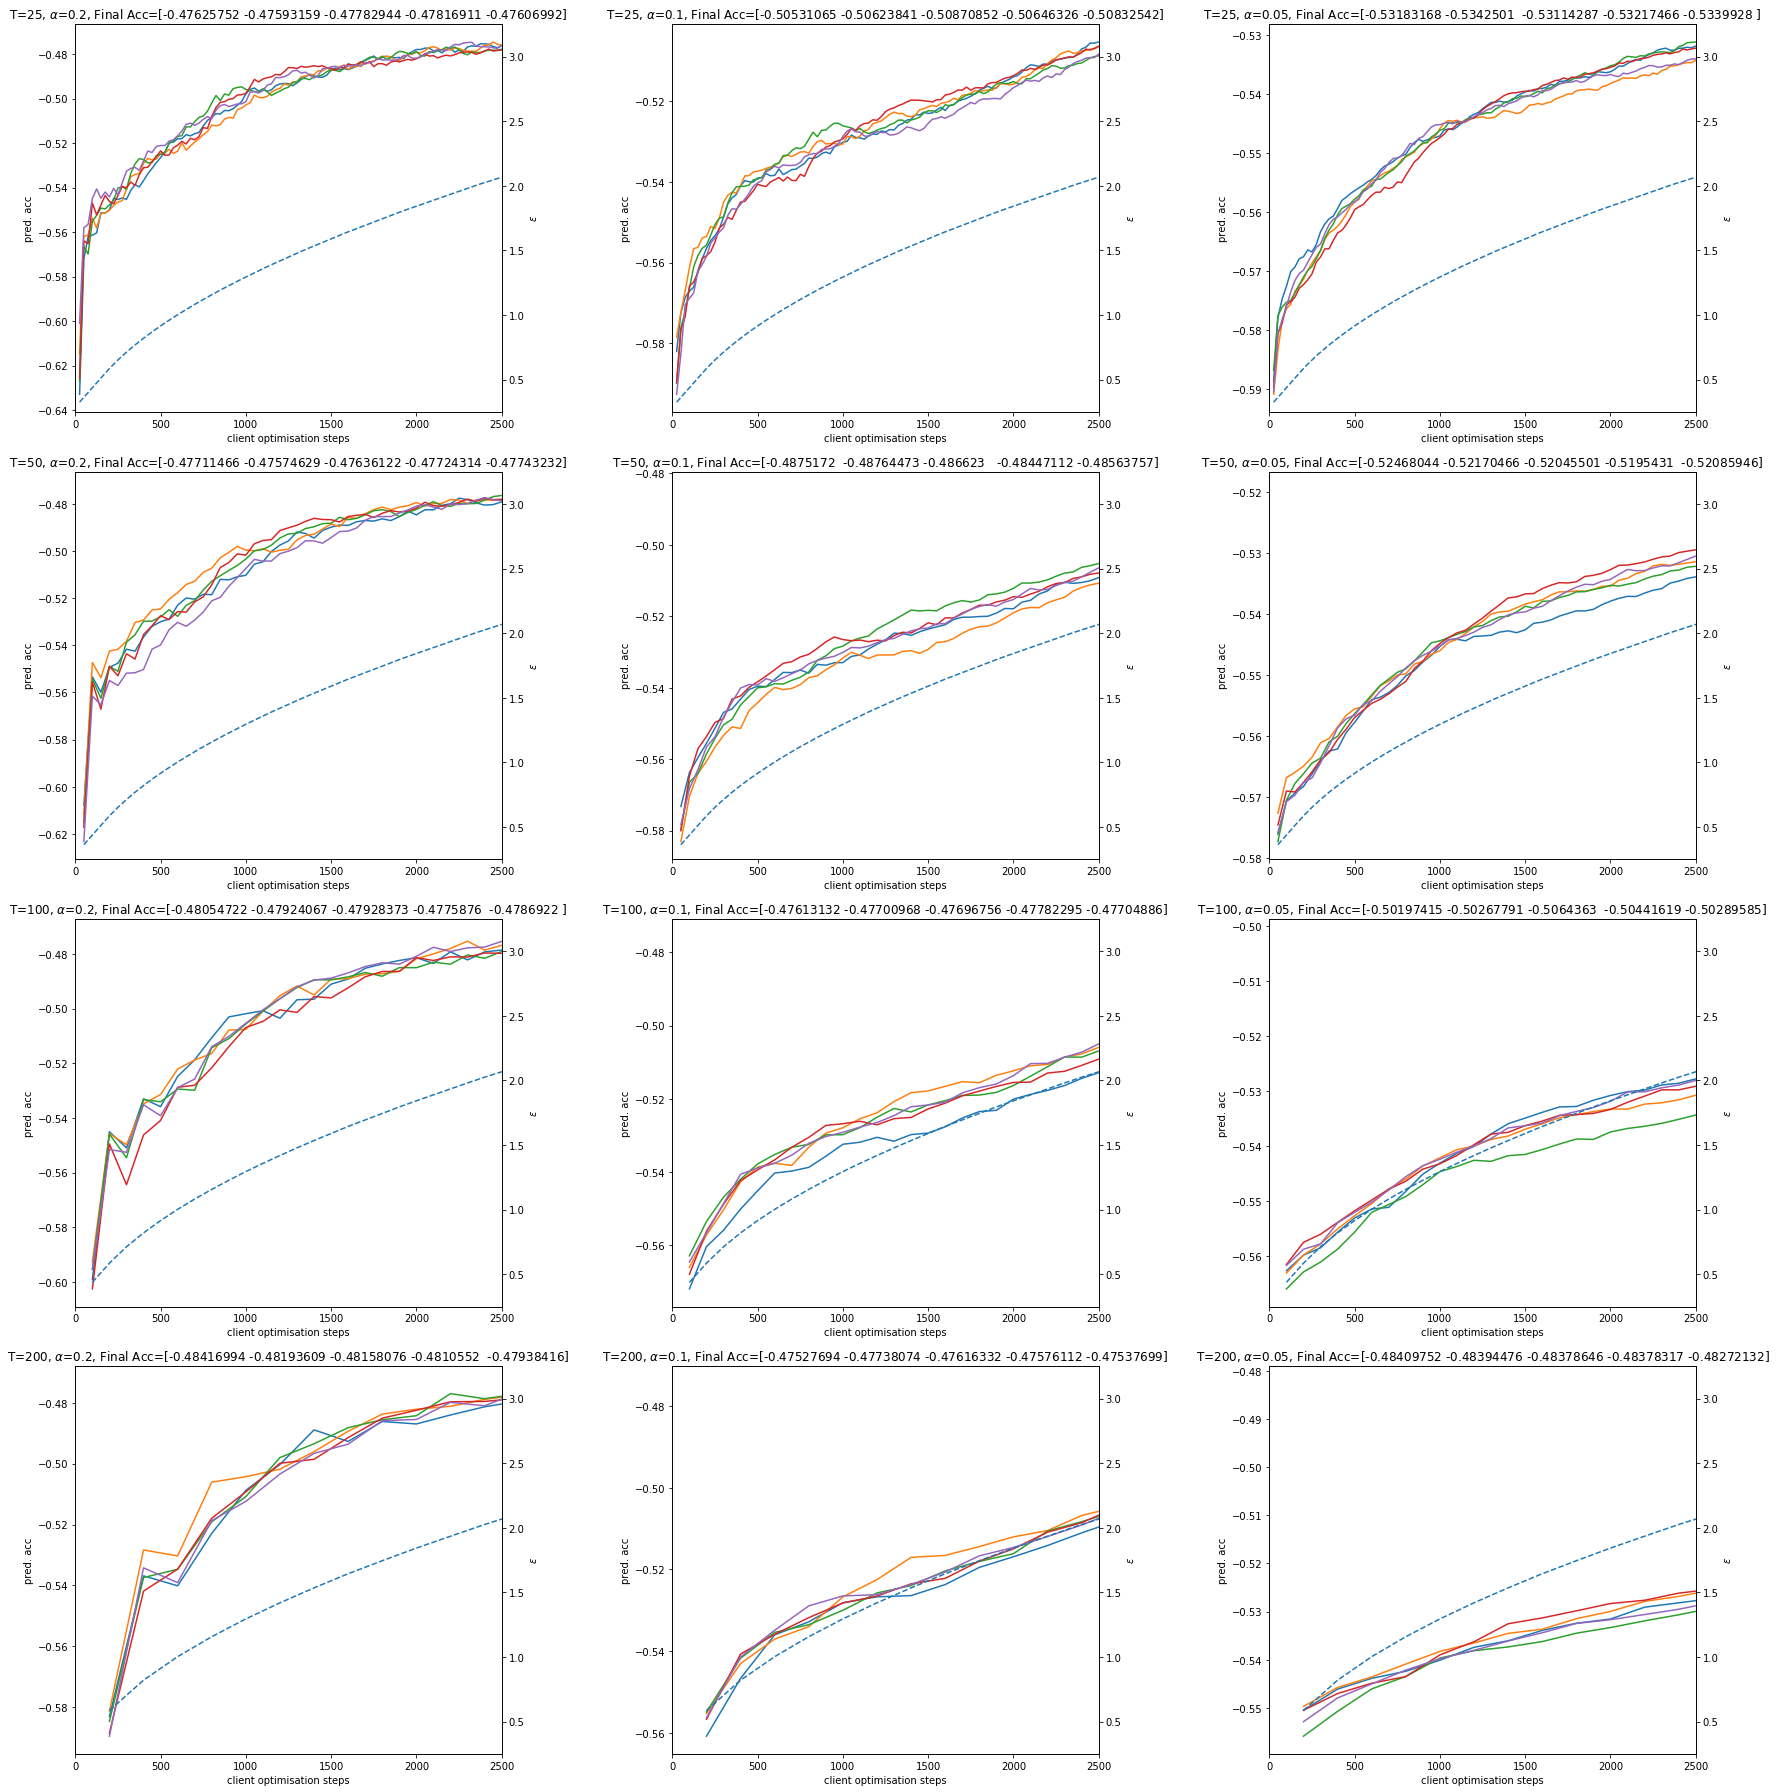

In [11]:
results_access = SacredExperimentAccess(database_name=database)
Ts = experiment_config['optimisation_settings.N_steps']
As = experiment_config['PVI_settings.damping_factor']

adult_grid_experiments = [results_access.get_experiments(name='jalko2017_datapoint_exp', complete=True, config=config) for config in adult_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_all", "train_accuracy"]) for experiments in adult_grid_experiments]
adult_eps_metrics = [results_access.get_metrics_by_exp(experiments, "epsilon", "in") for experiments in adult_grid_experiments]

plt.figure(figsize=(25,25))
rows = len(Ts)
cols = len(As)

for config, experiments, metrics, eps_metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics, adult_eps_metrics):
    T = config['optimisation_settings.N_steps']
    A = config['PVI_settings.damping_factor']
    
    T_index = Ts.index(T)
    A_index = As.index(A)
    
    axes = plt.subplot(rows, cols, T_index * cols + A_index + 1)
    
        
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T * T
    
    seed_eps_values = []
    for seed_indx, seed_eps in enumerate(eps_metrics):
        eps_values = []
        for client_eps in seed_eps:
            eps_values.append(np.array(client_eps["values"]).flatten())
        eps_values = np.array(eps_values)
        seed_eps_values.append(np.mean(eps_values, 0))
    
    final_mean_eps_values = np.mean(seed_eps_values, 0)
    
    axes2 = axes.twinx()
    
    plt.title(f"T={T}, $\\alpha$={A}, Final Acc={values[-1]}")
    
    axes2.plot(steps, final_mean_eps_values, '--')
    axes.plot(steps, values)
    axes.set_xlabel('client optimisation steps')
    axes.set_ylabel('pred. acc')
    axes2.set_ylabel('$\epsilon$')
    axes2.set_ylim(0.25, 3.25)
    plt.xlim([0,2500])
    
plt.tight_layout()